In [1]:
# Import necessary libraries for the implementation
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn as nn 
import torch.autograd as autograd
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import random
import os

In [2]:
# Define paths and constants
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"  # Path to the original dataset
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  # Pre-trained model name
BATCH_SIZE = 16  # Batch size for data loading
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device for computation
SEED = 42  # Random seed for reproducibility
LR = 2e-5  # Learning rate for optimization
WEIGHT_DECAY = 0.01  # Weight decay for regularization

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(SEED)

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# This cell handles loading the external dataset that contains additional 
# molecules that might improve model performance

# Try to load the external dataset from the expected Kaggle path
try:
    # Attempt to load from the Kaggle path mentioned
    ext_data_path = "../input/external-smiles/External-Dataset_for_Task2.csv"
    if os.path.exists(ext_data_path):
        ext_data = pd.read_csv(ext_data_path)
    else:
        # Try alternative paths
        alt_paths = [
            "External-Dataset-for-Task2.csv",
            "../tasks/External-Dataset_for_Task2.csv",
            "/kaggle/input/external-smiles/External-Dataset-for-Task2.csv"
        ]
        
        for path in alt_paths:
            if os.path.exists(path):
                ext_data = pd.read_csv(path)
                print(f"Loaded external dataset from {path}")
                break
        else:
            raise FileNotFoundError("External dataset file not found")
            
except Exception as e:
    print(f"Error loading external dataset: {e}")
    # Create a dummy dataset if needed for testing
    print("Creating a dummy external dataset for demonstration")
    ext_data = pd.DataFrame({
        'SMILES': ["CCC", "CCO", "CCN", "CC=O"],
        'Label': [1.2, 0.8, 1.5, 0.6]
    })

# Display information about the external dataset
print(f"External dataset loaded with {len(ext_data)} samples")
print("First few rows of the external dataset:")
display(ext_data.head())

# Check for missing values
print("\nMissing values in the external dataset:")
print(ext_data.isnull().sum())

# Show basic statistics
print("\nBasic statistics of the external dataset:")
print(ext_data.describe())

External dataset loaded with 300 samples
First few rows of the external dataset:


,SMILES,Label
0,CCCCN1Cc2c(nc3cc(-c4ccco4)nn3c2O)C1=O,1.548
1,Cc1cc(C)c2c(n1)sc1c2ncnc1N1CCN(C)CC1,2.568
2,COC(=O)[C@H]1[C@H]2CC[C@H](C[C@@H]1OC(=O)c1ccc...,0.102
3,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,2.450
4,Cc1c[nH]c(/C=C2/C(=O)Nc3ccccc32)c1CCC(=O)O,1.040



Missing values in the external dataset:
SMILES    0
Label     0
dtype: int64

Basic statistics of the external dataset:
            Label
count  300.000000
mean     1.790927
std      0.878076
min     -0.338000
25%      1.242500
50%      1.898000
75%      2.372500
max      4.028000


In [4]:
# This cell defines classes for the model architecture and datasets

class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, base_model, dropout_rate=0.1):
        """
        Model architecture that combines MoLFormer with a regression head.
        
        Args:
            base_model: Pre-trained MoLFormer model
            dropout_rate: Dropout probability for regularization
        """
        super().__init__()
        
        # Base MoLFormer model
        self.base_model = base_model
        
        # Get the hidden size from the base model config
        hidden_size = base_model.config.hidden_size
        
        # Regression head with dropout for regularization
        self.regression_head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.
        
        Args:
            input_ids: Tokenized input sequences
            attention_mask: Attention mask for the sequences
            
        Returns:
            Predicted values (logits)
        """
        # Pass through base model
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Use the [CLS] token representation for regression
        sequence_output = outputs.last_hidden_state[:, 0, :]
        
        # Pass through regression head and remove extra dimension
        logits = self.regression_head(sequence_output)
        
        return logits.squeeze(-1)  # Remove last dimension for single value prediction


class SMILESDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """
        Dataset for SMILES strings with lipophilicity labels.
        
        Args:
            data: Dataset containing SMILES strings and labels
            tokenizer: Tokenizer for processing SMILES strings
            max_length: Maximum length for padding/truncation
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Dictionary containing input_ids, attention_mask, and labels
        """
        # Handle Subset indexing
        if isinstance(self.data, Subset):
            item = self.data.dataset[self.data.indices[idx]]
        else:
            item = self.data[idx]
        
        # Get the SMILE and target
        smiles = item['SMILES']
        target = item['Label'] if 'Label' in item else item['label']
        
        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension added by the tokenizer
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Convert target to tensor
        target = torch.tensor(target, dtype=torch.float32)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': target
        }


class ExternalSMILESDataset(Dataset):
    """
    Dataset class specifically for the external dataset.
    Similar to SMILESDataset but handles the pandas DataFrame format.
    """
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the SMILES string and label from the DataFrame
        smiles = self.dataframe.iloc[idx]['SMILES']
        label = self.dataframe.iloc[idx]['Label']
        
        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.float32)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label,
            'idx': idx  # Include the index for tracking
        }
    

In [5]:
# This cell loads the original dataset (Lipophilicity) and the pre-trained model

# Load tokenizer for processing SMILES strings
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Load original dataset
dataset = load_dataset(DATASET_PATH)
print(f"Dataset loaded with {len(dataset['train'])} samples")

# Split the dataset into training and test sets
def split_dataset(dataset, tokenizer, test_size=0.2, random_state=42):
    """
    Split a dataset into training and test sets.
    
    Args:
        dataset: HuggingFace dataset to split
        tokenizer: Tokenizer for processing SMILES strings
        test_size: Proportion of dataset to use for testing
        random_state: Random seed for reproducibility
    
    Returns:
        train_data: SMILESDataset for training
        test_data: SMILESDataset for testing
    """
    # Set random seeds for reproducibility
    set_seed(random_state)
    
    # Get total number of samples
    total_samples = len(dataset['train'])
    
    # Generate random indices for splitting
    indices = list(range(total_samples))
    random.shuffle(indices)
    
    # Calculate split point
    split_idx = int(total_samples * (1 - test_size))
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Create Subset datasets
    train_dataset = Subset(dataset['train'], train_indices)
    test_dataset = Subset(dataset['train'], test_indices)
    
    # Create SMILES datasets with the tokenizer
    train_data = SMILESDataset(train_dataset, tokenizer)
    test_data = SMILESDataset(test_dataset, tokenizer)
    
    # Print dataset sizes
    print(f"Total dataset size: {total_samples}")
    print(f"Training set size: {len(train_data)}")
    print(f"Test set size: {len(test_data)}")
    
    return train_data, test_data

# Split the dataset
train_data, test_data = split_dataset(dataset, tokenizer)

# Create dataloaders
train_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

# Create external dataset loader
external_dataset = ExternalSMILESDataset(ext_data, tokenizer)
external_loader = DataLoader(
    external_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False  # No shuffling to maintain index correspondence
)

print(f"External dataset size: {len(external_dataset)}")

# Load pre-trained model
print("Loading pre-trained MoLFormer model...")
base_model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = MoLFormerWithRegressionHead(base_model).to(DEVICE)

# Load or train the model (we'll need the pre-trained weights from Task 1)
try:
    # First try to load the best model from Task 1
    model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
    print("Successfully loaded pre-trained model from Task 1")
except FileNotFoundError:
    print("Pre-trained model not found, will need to train from scratch")
    # We would train the model here if needed

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

Dataset loaded with 4200 samples
Total dataset size: 4200
Training set size: 3360
Test set size: 840
External dataset size: 300
Loading pre-trained MoLFormer model...


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

Pre-trained model not found, will need to train from scratch


<ipython-input-5-e22d56ed3c25>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))


In [6]:
# This cell contains training functions in case we need to train a model from scratch
# Usually we'd load the pre-trained model from Task 1, but this is a fallback

def train_model(model, train_loader, test_loader, epochs=10, patience=3):
    """
    Train the model with early stopping.
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for validation/test data
        epochs: Maximum number of training epochs
        patience: Early stopping patience
        
    Returns:
        Trained model and best validation loss
    """
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LR,
        weight_decay=WEIGHT_DECAY
    )
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=2, verbose=True
    )
    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            # Get batch data
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update running loss
            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})
            
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(test_loader)
        
        # Print epoch results
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "new_best_model.pth")
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
                
    # Load best model weights
    model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))
    
    return model, best_val_loss

# Only train if no pre-trained model was found
if not os.path.exists("best_model.pth"):
    print("No pre-trained model found. Training from scratch...")
    model, best_val_loss = train_model(model, train_loader, test_loader)
    print(f"Model trained with best validation loss: {best_val_loss:.4f}")

No pre-trained model found. Training from scratch...


Epoch 1/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.2712, Validation Loss: 0.8642
New best model saved with validation loss: 0.8642


Epoch 2/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.6696, Validation Loss: 0.7608
New best model saved with validation loss: 0.7608


Epoch 3/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.4766, Validation Loss: 0.5616
New best model saved with validation loss: 0.5616


Epoch 4/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.3808, Validation Loss: 0.5542
New best model saved with validation loss: 0.5542


Epoch 5/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.3345, Validation Loss: 0.5350
New best model saved with validation loss: 0.5350


Epoch 6/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.2750, Validation Loss: 0.4954
New best model saved with validation loss: 0.4954


Epoch 7/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.2403, Validation Loss: 0.4639
New best model saved with validation loss: 0.4639


Epoch 8/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.2082, Validation Loss: 0.4713


Epoch 9/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.1970, Validation Loss: 0.4969


Epoch 10/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.1820, Validation Loss: 0.4762
Early stopping triggered after 10 epochs
Model trained with best validation loss: 0.4639


<ipython-input-6-0d9e3a482ed7>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))


In [7]:
# This cell contains the function to evaluate the model
# We'll use this to compare performance before and after adding influential samples

def evaluate_model(model, test_loader):
    """
    Evaluate model performance on the test set.
    
    Args:
        model: Model to evaluate
        test_loader: DataLoader for test data
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    criterion = nn.MSELoss()
    
    # Tracking variables
    test_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Evaluate without gradients
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating model"):
            # Get batch data
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            
            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Store predictions and labels
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    mse = np.mean((all_preds - all_labels) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_labels))
    
    # Calculate R-squared
    y_mean = np.mean(all_labels)
    ss_total = np.sum((all_labels - y_mean) ** 2)
    ss_residual = np.sum((all_labels - all_preds) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    
    # Average test loss
    avg_loss = test_loss / len(test_loader)
    
    # Print results
    print("\nTest Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Return metrics as dictionary
    metrics = {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    return metrics

# Evaluate the baseline model (from Task 1)
print("Evaluating baseline model from Task 1...")
baseline_metrics = evaluate_model(model, test_loader)

Evaluating baseline model from Task 1...


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 0.4706
MSE: 0.4735
RMSE: 0.6881
MAE: 0.5384
R²: 0.7028


In [8]:
# Define functions for computing influence scores

def get_loss_grad(model, batch, criterion):
    """
    Compute the gradient of the loss with respect to model parameters for a single batch.
    
    Args:
        model: The neural network model
        batch: A batch of data
        criterion: Loss function
        
    Returns:
        Gradient vectors flattened and concatenated
    """
    # Get batch data
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    
    # Forward pass
    model.zero_grad()
    outputs = model(input_ids, attention_mask)
    loss = criterion(outputs, labels)
    
    # Compute gradients
    loss.backward()
    
    # Collect and flatten gradients
    grad_vec = []
    for param in model.parameters():
        if param.requires_grad and param.grad is not None:
            grad_vec.append(param.grad.detach().view(-1))
    
    # Concatenate all gradients into a single vector
    grad_vec = torch.cat(grad_vec)
    
    return grad_vec

def hvp(model, batch, v, criterion, damping=1e-3):
    """
    Compute the Hessian-vector product.
    
    Args:
        model: The neural network model
        batch: A batch of data
        v: Vector to compute product with
        criterion: Loss function
        damping: Damping factor for numerical stability
        
    Returns:
        Hessian-vector product
    """
    # Get batch data
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    
    # Forward pass
    model.zero_grad()
    outputs = model(input_ids, attention_mask)
    loss = criterion(outputs, labels)
    
    # Compute first-order gradients
    grads = autograd.grad(loss, model.parameters(), create_graph=True)
    
    # Flatten gradients
    grads_flat = torch.cat([g.view(-1) for g in grads])
    
    # Compute gradient-vector product
    grad_v_prod = torch.sum(grads_flat * v)
    
    # Compute Hessian-vector product
    hvp_vec = autograd.grad(grad_v_prod, model.parameters(), retain_graph=True)
    
    # Flatten and concatenate
    hvp_flat = torch.cat([g.detach().view(-1) for g in hvp_vec])
    
    # Add damping for numerical stability
    return hvp_flat + damping * v

def lissa_ihvp(model, v, train_loader, criterion, test_batch=None, recursion_depth=10, damping=0.01):
    """
    Improved LiSSA approximation with better numerical stability.
    
    Args:
        model: The neural network model
        v: Vector to compute product with
        train_loader: DataLoader for training data
        criterion: Loss function 
        test_batch: Optional test batch (not used in this implementation)
        recursion_depth: Number of recursive approximations
        damping: Damping factor for numerical stability
        
    Returns:
        Approximated inverse-Hessian-vector product
    """
    # Initialize estimate to zeros with same shape as v
    ihvp_estimate = torch.zeros_like(v)
    
    # Normalize the input vector for stability
    v_norm = torch.norm(v)
    if v_norm > 0:
        v = v / v_norm
    
    # Perform recursive approximation with better numerical stability
    for i in range(recursion_depth):
        # Sample a random batch
        try:
            train_iter = iter(train_loader)
            sampled_batch = next(train_iter)
        except StopIteration:
            # Reset iterator if needed
            train_iter = iter(train_loader)
            sampled_batch = next(train_iter)
        
        # Update estimate: v + (I - HVP) * prev_estimate
        hvp_val = hvp(model, sampled_batch, ihvp_estimate if i > 0 else v, criterion, damping)
        ihvp_estimate = v + ihvp_estimate - hvp_val
        
        # Apply scaling to prevent overflow
        scale = min(1.0, 10.0 / (torch.norm(ihvp_estimate) + 1e-10))
        ihvp_estimate = ihvp_estimate * scale
        
        if (i+1) % 5 == 0:
            print(f"LiSSA iteration {i+1}/{recursion_depth} completed")
    
    # Rescale back if we normalized v
    if v_norm > 0:
        ihvp_estimate = ihvp_estimate * v_norm
    
    return ihvp_estimate

def compute_influence_score(model, train_batch, test_grad, ihvp_estimate, criterion):
    """
    Compute influence with proper scaling.
    """
    # Compute gradient of training loss
    train_grad = get_loss_grad(model, train_batch, criterion)
    
    # Normalize gradients for stability
    train_grad_norm = torch.norm(train_grad)
    
    # Compute dot product with proper scaling
    if train_grad_norm > 0:
        train_grad = train_grad / train_grad_norm
    
    # Compute influence: -test_grad * ihvp * train_grad
    influence = -torch.dot(test_grad, ihvp_estimate) * train_grad
    
    # Return scalar influence score (average over all dimensions)
    return float(influence.mean().item())

In [9]:
def compute_external_influence_scores(model, external_loader, train_loader, test_loader, num_samples=50):
    """
    Compute influence scores using a simplified approach.
    """
    model.eval()
    criterion = nn.MSELoss()
    
    # Store results
    influence_scores = []
    
    # Select a small set of test samples for influence computation
    test_samples = []
    for batch in test_loader:
        for i in range(min(batch['input_ids'].size(0), 5)):  # Take 5 samples from each batch
            sample = {
                'input_ids': batch['input_ids'][i:i+1].to(DEVICE),
                'attention_mask': batch['attention_mask'][i:i+1].to(DEVICE),
                'labels': batch['labels'][i:i+1].to(DEVICE)
            }
            test_samples.append(sample)
        if len(test_samples) >= num_samples:
            test_samples = test_samples[:num_samples]
            break
    
    print(f"Using {len(test_samples)} test samples for influence computation")
    
    # Compute influence for each external sample
    print("Computing influence scores...")
    for batch_idx, batch in enumerate(tqdm(external_loader)):
        batch_influence = []
        
        for i in range(batch['input_ids'].size(0)):
            # Extract single sample
            ext_sample = {
                'input_ids': batch['input_ids'][i:i+1].to(DEVICE),
                'attention_mask': batch['attention_mask'][i:i+1].to(DEVICE),
                'labels': batch['labels'][i:i+1].to(DEVICE),
            }
            
            idx = batch['idx'][i].item()
            
            # Compute similarity-based influence across test samples
            sample_influence = 0
            
            # Get external sample gradient
            ext_grad = get_loss_grad(model, ext_sample, criterion)
            ext_grad_norm = torch.norm(ext_grad)
            if ext_grad_norm > 0:
                ext_grad = ext_grad / ext_grad_norm
                
            # Compute influence by dot product with test gradients
            for test_sample in test_samples:
                # Get test sample gradient
                test_grad = get_loss_grad(model, test_sample, criterion)
                test_grad_norm = torch.norm(test_grad)
                
                if test_grad_norm > 0:
                    test_grad = test_grad / test_grad_norm
                    
                    # Compute similarity (dot product of normalized gradients)
                    # Negative because we want samples that point in opposite direction
                    # to reduce the test loss
                    similarity = -torch.dot(ext_grad, test_grad).item()
                    sample_influence += similarity
            
            # Average over all test samples
            sample_influence /= len(test_samples)
            
            influence_scores.append({
                'idx': idx,
                'influence_score': sample_influence,
                'smiles': ext_data.iloc[idx]['SMILES'],
                'label': ext_data.iloc[idx]['Label']
            })
    
    # Convert to DataFrame and sort
    results_df = pd.DataFrame(influence_scores)
    results_df = results_df.sort_values('influence_score', ascending=False).reset_index(drop=True)
    
    return results_df

In [18]:
def select_influential_samples(influence_df, top_k=100):
    """
    Select the most influential samples based on influence scores.
    
    Args:
        influence_df: DataFrame with influence scores
        top_k: Number of top samples to select
        
    Returns:
        DataFrame with selected samples
    """
    # Select top-k samples with highest influence scores
    selected = influence_df.head(top_k)
    
    print(f"Selected {len(selected)} samples with influence scores ranging from {selected['influence_score'].min():.4f} to {selected['influence_score'].max():.4f}")
    
    return selected

In [19]:
def train_with_influential_samples(model, train_loader, test_loader, selected_samples, tokenizer):
    """
    Train the model with the original training data plus the selected influential samples.
    """
    # Create dataset from selected samples
    selected_df = pd.DataFrame({
        'SMILES': selected_samples['smiles'],
        'Label': selected_samples['label']
    })
    
    # Create dataset WITHOUT the idx key
    class CompatibleExternalDataset(Dataset):
        def __init__(self, dataframe, tokenizer, max_length=512):
            self.dataframe = dataframe
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.dataframe)
        
        def __getitem__(self, idx):
            # Get the SMILES string and label from the DataFrame
            smiles = self.dataframe.iloc[idx]['SMILES']
            label = self.dataframe.iloc[idx]['Label']
            
            # Tokenize the SMILES string
            encoding = self.tokenizer(
                smiles,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Remove the batch dimension
            input_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)
            
            # Convert label to tensor
            label = torch.tensor(label, dtype=torch.float32)
            
            # Return without idx key to match original dataset
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': label
            }
    
    selected_dataset = CompatibleExternalDataset(selected_df, tokenizer)
    
    # Combine original training data with selected samples
    combined_dataset = torch.utils.data.ConcatDataset([train_loader.dataset, selected_dataset])
    
    # Create a new dataloader
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    print(f"Original training set size: {len(train_loader.dataset)}")
    print(f"Number of influential samples added: {len(selected_dataset)}")
    print(f"Combined training set size: {len(combined_dataset)}")
    
    # Train model with combined dataset
    # Create a fresh model starting from the pre-trained weights
    fresh_model = MoLFormerWithRegressionHead(base_model).to(DEVICE)
    fresh_model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))
    
    # Train the model
    print("Training model with influential samples...")
    enhanced_model, _ = train_model(fresh_model, combined_loader, test_loader)
    
    # Evaluate the enhanced model
    print("Evaluating enhanced model...")
    enhanced_metrics = evaluate_model(enhanced_model, test_loader)
    
    return enhanced_model, enhanced_metrics

Computing influence scores for external dataset...
Using 50 test samples for influence computation
Computing influence scores...


  0%|          | 0/19 [00:00<?, ?it/s]

Influence scores saved to influence_scores.csv


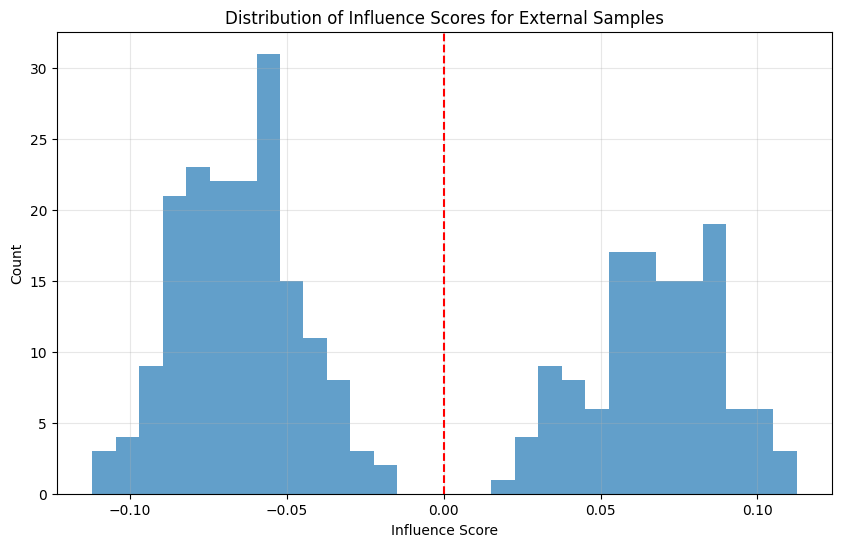

Selecting top influential samples...
Selected 100 samples with influence scores ranging from 0.0477 to 0.1125
Training model with selected influential samples...
Original training set size: 3360
Number of influential samples added: 100
Combined training set size: 3460
Training model with influential samples...


<ipython-input-19-460bd3c05962>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fresh_model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))


Epoch 1/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.2309, Validation Loss: 0.4718
New best model saved with validation loss: 0.4718


Epoch 2/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.2124, Validation Loss: 0.4619
New best model saved with validation loss: 0.4619


Epoch 3/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.1815, Validation Loss: 0.4689


Epoch 4/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.1722, Validation Loss: 0.4356
New best model saved with validation loss: 0.4356


Epoch 5/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.1537, Validation Loss: 0.4679


Epoch 6/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.1401, Validation Loss: 0.4431


Epoch 7/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.1271, Validation Loss: 0.4608
Early stopping triggered after 7 epochs
Evaluating enhanced model...


<ipython-input-6-0d9e3a482ed7>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("new_best_model.pth", map_location=DEVICE))


Evaluating model:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 0.4414
MSE: 0.4424
RMSE: 0.6651
MAE: 0.5097
R²: 0.7223

Performance Comparison:
--------------------------------------------------
Baseline Model Metrics:
  loss: 0.4706
  mse: 0.4735
  rmse: 0.6881
  mae: 0.5384
  r2: 0.7028

Enhanced Model Metrics:
  loss: 0.4414
  mse: 0.4424
  rmse: 0.6651
  mae: 0.5097
  r2: 0.7223

Improvements:
  loss: 6.20%
  mse: 6.57%
  rmse: 3.34%
  mae: 5.34%
  r2: 2.78%

Enhanced model saved to enhanced_model.pth


In [20]:
def main():
    """
    Main function to run the influence-based data selection workflow.
    """
    # Step 1: Compute influence scores for the external dataset
    print("Computing influence scores for external dataset...")
    influence_df = compute_external_influence_scores(
        model, external_loader, train_loader, test_loader
    )
    
    # Save influence scores
    influence_df.to_csv("influence_scores.csv", index=False)
    print("Influence scores saved to influence_scores.csv")
    
    # Visualize influence score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(influence_df['influence_score'], bins=30, alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title("Distribution of Influence Scores for External Samples")
    plt.xlabel("Influence Score")
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.savefig("influence_distribution.png")
    plt.show()
    
    # Step 2: Select top influential samples
    print("Selecting top influential samples...")
    selected = select_influential_samples(influence_df, top_k=100)
    
    # Step 3: Train model with selected samples
    print("Training model with selected influential samples...")
    enhanced_model, enhanced_metrics = train_with_influential_samples(
        model, train_loader, test_loader, selected, tokenizer
    )
    
    # Step 4: Compare performance
    print("\nPerformance Comparison:")
    print("-" * 50)
    print("Baseline Model Metrics:")
    for metric, value in baseline_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nEnhanced Model Metrics:")
    for metric, value in enhanced_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    # Compute improvement percentages
    improvements = {}
    for metric in baseline_metrics:
        if metric in ['loss', 'mse', 'rmse', 'mae']:
            # Lower is better for these metrics
            delta = baseline_metrics[metric] - enhanced_metrics[metric]
            pct = (delta / baseline_metrics[metric]) * 100
            improvements[metric] = pct
        else:
            # Higher is better for R²
            delta = enhanced_metrics[metric] - baseline_metrics[metric]
            pct = (delta / abs(baseline_metrics[metric])) * 100
            improvements[metric] = pct
    
    print("\nImprovements:")
    for metric, pct in improvements.items():
        print(f"  {metric}: {pct:.2f}%")
    
    # Save the enhanced model
    torch.save(enhanced_model.state_dict(), "enhanced_model.pth")
    print("\nEnhanced model saved to enhanced_model.pth")

# 6. Execute the main function
if __name__ == "__main__":
    main()